Subject 1035 — 2025-03-30: total beats = 96629, nonempty 1-min bins = 1200/1436
Saved: /Users/orduek/Library/CloudStorage/OneDrive-BGU/PTSD Cohort/data/bbi/bbi_counts_1035_2025-03-30.csv


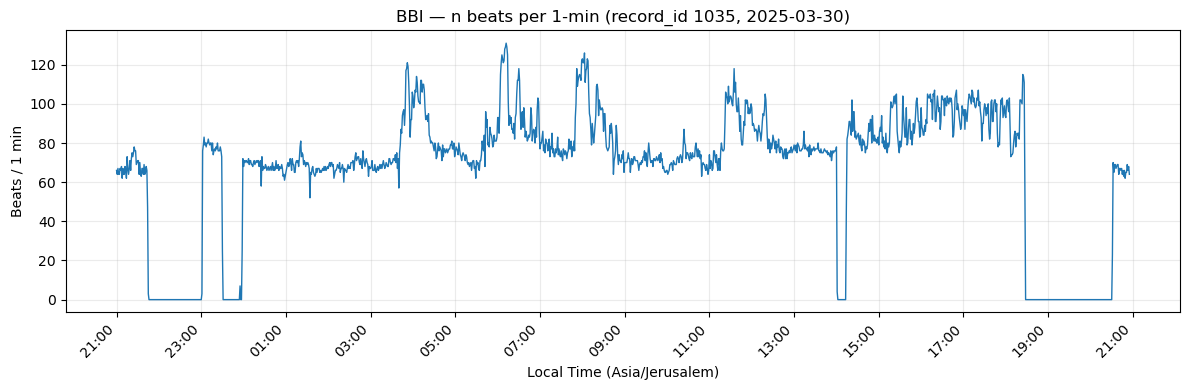

In [2]:
# ============================
# BBI counts per 5-minute bin
# ============================

import os, io, re
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --------- CONFIG: set these ---------
ROOT_BBI = "/Users/orduek/Library/CloudStorage/OneDrive-BGU/PTSD Cohort/data"  # top folder of your Labfront export
RECORD_ID = "1035"          # subject id as it appears in filenames: ...garmin-device-bbi_<RECORD_ID>_*.csv
DAY = "2025-03-30"          # the local calendar date in Israel time (YYYY-MM-DD)
TZ = "Asia/Jerusalem"
OUT_CSV = f"/Users/orduek/Library/CloudStorage/OneDrive-BGU/PTSD Cohort/data/bbi/bbi_counts_{RECORD_ID}_{DAY}.csv"
# -------------------------------------

# ---- helpers ----
def read_labfront_data_table(csv_path: str) -> pd.DataFrame:
    """Labfront CSVs have a metadata block, blank line, then the real header+data."""
    with open(csv_path, "r", encoding="utf-8") as f:
        lines = f.read().splitlines()
    sep = next((i for i, ln in enumerate(lines) if ln.strip() == ""), None)
    if sep is None:
        # occasionally files are already 'clean'
        return pd.read_csv(csv_path)
    return pd.read_csv(io.StringIO("\n".join(lines[sep+1:])))

def find_bbi_files(root: str, record_id: str) -> list[str]:
    """Find BBI files for a subject recursively under root."""
    rid = str(int(float(record_id))) if re.match(r"^\d+(\.0+)?$", str(record_id)) else str(record_id).strip()
    pattern = os.path.join(root, "**", "garmin-device-bbi", "*.csv")
    files = [f for f in glob(pattern, recursive=True) if re.search(fr"garmin-device-bbi_{rid}_", os.path.basename(f))]
    return sorted(files)

def parse_ts(df: pd.DataFrame, tz: str) -> pd.DatetimeIndex:
    """Prefer unixTimestampInMs (UTC) → tz, else isoDate."""
    if "unixTimestampInMs" in df.columns:
        ts = pd.to_datetime(df["unixTimestampInMs"], unit="ms", utc=True).dt.tz_convert(tz)
    elif "unixTimestamp" in df.columns:
        ts = pd.to_datetime(df["unixTimestamp"], unit="s", utc=True).dt.tz_convert(tz)
    elif "isoDate" in df.columns:
        raw = pd.to_datetime(df["isoDate"], errors="coerce")
        ts = raw.dt.tz_convert(tz) if getattr(raw.dt, "tz", None) is not None else raw.dt.tz_localize(tz)
    else:
        raise ValueError("No timestamp column found (need unixTimestampInMs / unixTimestamp / isoDate).")
    return ts

def detect_bbi_col(df: pd.DataFrame) -> str | None:
    """Find the column containing RR intervals in ms."""
    candidates = [c for c in df.columns if re.search(r"\b(bbi|ibi|rr(interval)?|rr_ms|bbiinms)\b", c, re.I)]
    if candidates:
        for c in candidates:
            if c.lower() == "bbi":
                return c
        return candidates[0]
    # fallback: most values in plausible RR range
    numeric = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    best, best_ratio = None, 0.0
    for c in numeric:
        s = pd.to_numeric(df[c], errors="coerce")
        ratio = s.between(300, 2000).mean()
        if ratio > best_ratio:
            best_ratio, best = ratio, c
    return best

# ---- load all BBI for that subject & day ----
files = find_bbi_files(ROOT_BBI, RECORD_ID)
if not files:
    raise FileNotFoundError(f"No BBI files found for record_id={RECORD_ID} under {ROOT_BBI}")

frames = []
for f in files:
    try:
        d = read_labfront_data_table(f)
        ts = parse_ts(d, TZ)
        bcol = detect_bbi_col(d)
        if bcol is None:
            print(f"[WARN] No BBI column in {os.path.basename(f)} — skipping.")
            continue
        frame = pd.DataFrame({"BBI": pd.to_numeric(d[bcol], errors="coerce")}, index=ts)
        frames.append(frame)
    except Exception as e:
        print(f"[SKIP] {os.path.basename(f)}: {e}")

if not frames:
    raise RuntimeError("Could not load any BBI data after parsing.")

bbi = pd.concat(frames).sort_index()
bbi.index.name = "ts_il"

# ---- slice the requested local calendar day ----
day0 = pd.Timestamp(DAY).tz_localize(TZ)
day1 = day0 + pd.Timedelta(days=1)
bbi_day = bbi.loc[(bbi.index >= day0) & (bbi.index < day1)].copy()

if bbi_day.empty:
    raise RuntimeError(f"No BBI samples on {DAY} (Israel time) for record_id={RECORD_ID}.")

# ---- aggregate: n beats per 5-minute window ----
# we count rows (one beat per row in BBI files)
counts_1m = bbi_day["BBI"].resample("1min").size().rename("n_beats")

# fill full 24h grid so gaps show explicitly as 0
full_idx = pd.date_range(day0, day1 - pd.Timedelta(minutes=5), freq="1min", tz=TZ)
counts_1m = counts_1m.reindex(full_idx).fillna(0).astype(int)
counts_df = counts_1m.reset_index().rename(columns={"index":"time_il"})

# ---- quick coverage stats ----
total_beats = int(counts_1m.sum())
nonempty_bins = int((counts_1m > 0).sum())
print(f"Subject {RECORD_ID} — {DAY}: total beats = {total_beats}, nonempty 1-min bins = {nonempty_bins}/{len(counts_1m)}")

# ---- save ----
counts_df.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

# ---- plot 24h line ----
plt.figure(figsize=(12,4))
plt.plot(counts_1m.index, counts_1m.values, linewidth=1)
plt.title(f"BBI — n beats per 1-min (record_id {RECORD_ID}, {DAY})")
plt.ylabel("Beats / 1 min")
plt.xlabel("Local Time (Asia/Jerusalem)")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

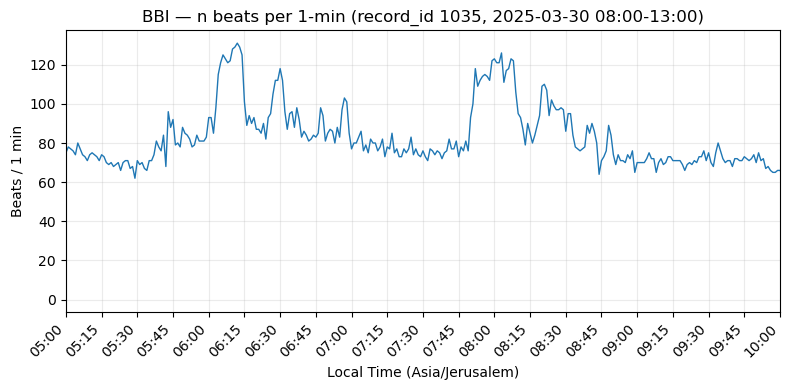

In [3]:
# Show graph between 19:00 to 20:30 Israel time (Asia/Jerusalem)
plt.figure(figsize=(8,4))
plt.plot(counts_1m.index, counts_1m.values, linewidth=1)
plt.xlim(
    pd.Timestamp(DAY).tz_localize(TZ) + pd.Timedelta(hours=8),
    pd.Timestamp(DAY).tz_localize(TZ) + pd.Timedelta(hours=13)
)
plt.title(f"BBI — n beats per 1-min (record_id {RECORD_ID}, {DAY} 08:00-13:00)")
plt.ylabel("Beats / 1 min")
plt.xlabel("Local Time (Asia/Jerusalem)")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=ax.xaxis.get_major_locator().tz))
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

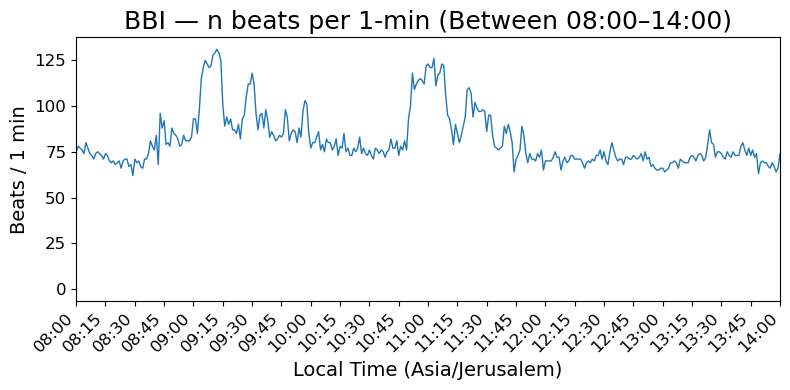

In [4]:
# Show graph between 08:00 to 13:00 Israel time
plt.figure(figsize=(8,4))
plt.plot(counts_1m.index, counts_1m.values, linewidth=1)

# Time window
t_start = pd.Timestamp(DAY).tz_localize(TZ) + pd.Timedelta(hours=8)
t_end   = pd.Timestamp(DAY).tz_localize(TZ) + pd.Timedelta(hours=14)
plt.xlim(t_start, t_end)

# Larger fonts
title_fs = 18
label_fs = 14
tick_fs = 12

ax = plt.gca()
ax.set_title("BBI — n beats per 1-min (Between 08:00–14:00)", fontsize=title_fs)
ax.set_ylabel("Beats / 1 min", fontsize=label_fs)
ax.set_xlabel("Local Time (Asia/Jerusalem)", fontsize=label_fs)

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=pd.Timestamp.now(tz=TZ).tzinfo))

plt.xticks(rotation=45, ha="right")
ax.tick_params(axis='both', labelsize=tick_fs)

plt.grid(False)
plt.tight_layout()
plt.savefig("bbi_hrv.png", dpi=300, bbox_inches='tight')
plt.show()